# DM - Clustering analysis [TASK 2]

Explore the dataset using various clustering techniques.

Library imports and initial settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.silhouette import silhouette


from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users dataset saved in data preparation phase.

In [2]:
# Load the users dataset from pickle
dataset = fetch_preprocessed_dataset(step_name="users_total")
users = dataset['users.pickle']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num_cols = ['statuses_count', 'bot', 'tweets_num', 'tweets_2020_num', 'likes_num', 'comments_num', 'ratio_likes_x_tweets', 'entropy', 'texts_mean_length', 'texts_special_chars_length', 'mean_pub_range', 'mean_texts_similarity']
users_num = users[users_num_cols].astype({'bot': 'int64'})

users_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   statuses_count              11508 non-null  int64  
 1   bot                         11508 non-null  int64  
 2   tweets_num                  11508 non-null  int64  
 3   tweets_2020_num             11508 non-null  int64  
 4   likes_num                   11508 non-null  float64
 5   comments_num                11508 non-null  float64
 6   ratio_likes_x_tweets        11508 non-null  float64
 7   entropy                     11508 non-null  float64
 8   texts_mean_length           11508 non-null  float64
 9   texts_special_chars_length  11508 non-null  float64
 10  mean_pub_range              11508 non-null  float64
 11  mean_texts_similarity       11508 non-null  float64
dtypes: float64(8), int64(4)
memory usage: 1.1 MB


## Scaling phase

It's used `MinMaxScaler` to rescale all numerical numbers between 0 and 1

In [4]:
scaler = MinMaxScaler()
scaler.fit(users_num.values)

MinMaxScaler()

Using transform function we are able to scale our values. Scaler is useful also for the inverse transformation.

In [5]:
users_num_scaled = scaler.transform(users_num.values)

users_num_scaled

array([[1.90211610e-04, 1.00000000e+00, 2.98089172e-02, ...,
        1.89594009e-02, 1.45447912e-04, 5.05482445e-01],
       [1.35150355e-04, 0.00000000e+00, 2.62420382e-02, ...,
        1.70393560e-02, 1.65050158e-04, 5.07759577e-01],
       [7.50835304e-06, 1.00000000e+00, 5.09554140e-04, ...,
        2.01550388e-02, 5.11440762e-05, 6.66666667e-01],
       ...,
       [1.50167061e-05, 0.00000000e+00, 1.27388535e-03, ...,
        3.10077519e-02, 2.62304545e-02, 5.36772240e-01],
       [1.05116943e-04, 1.00000000e+00, 2.29299363e-02, ...,
        1.90646563e-02, 1.88945221e-04, 5.06401825e-01],
       [1.32121986e-02, 0.00000000e+00, 8.40764331e-01, ...,
        1.44240998e-02, 3.06187124e-06, 5.07898686e-01]])

## Base clustering

We use base clustering methods to analyze the `users` dataset.

### KMeans

Firstly we run kmeans algorithms several times and we create a list of SSE measures to understand which is the proper number to asign to k.

In [6]:
sse_list = []
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(users_num_scaled)

    sse = kmeans.inertia_
    sse_list.append(sse)

We plot results below.

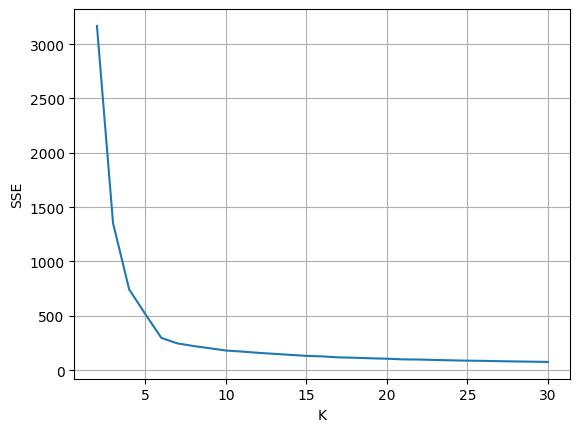

In [7]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.grid(True)
plt.show()

Now we build our model with the proper k and print different metrics to understand the goodness of our model.

In [8]:
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=100)
kmeans.fit(users_num_scaled)

lg.info(f'SSE: {kmeans.inertia_}')
lg.info(f'Silhouette: {silhouette_score(users_num_scaled, kmeans.labels_)}')
lg.info(f'Separation {metrics.davies_bouldin_score(users_num_scaled, kmeans.labels_)}')

2022-12-18 16:17:09,308 - root - INFO - SSE: 296.7458992402158
2022-12-18 16:17:10,304 - root - INFO - Silhouette: 0.758553118379583
2022-12-18 16:17:10,307 - root - INFO - Separation 0.3854774355046853


Here we plot the distribution of labels among different clusters.

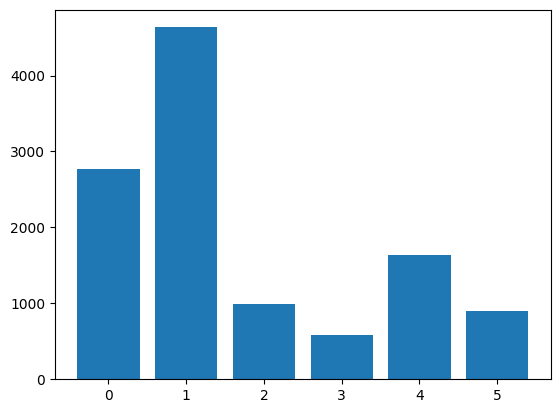

In [9]:
labels_distribution = np.unique(kmeans.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

Parallel coordinates plot used to see distinguishability of clusters for each attribute.

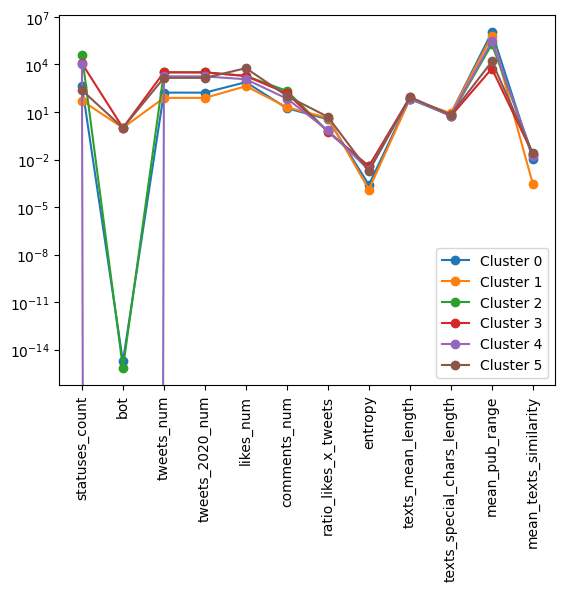

In [10]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label=f'Cluster {i}')
plt.xticks(range(0, len(users_num.columns)), users_num.columns, rotation=90)
plt.legend(fontsize=10)
plt.yscale('log')
plt.show()

Scatter-plots for some attribute couples.

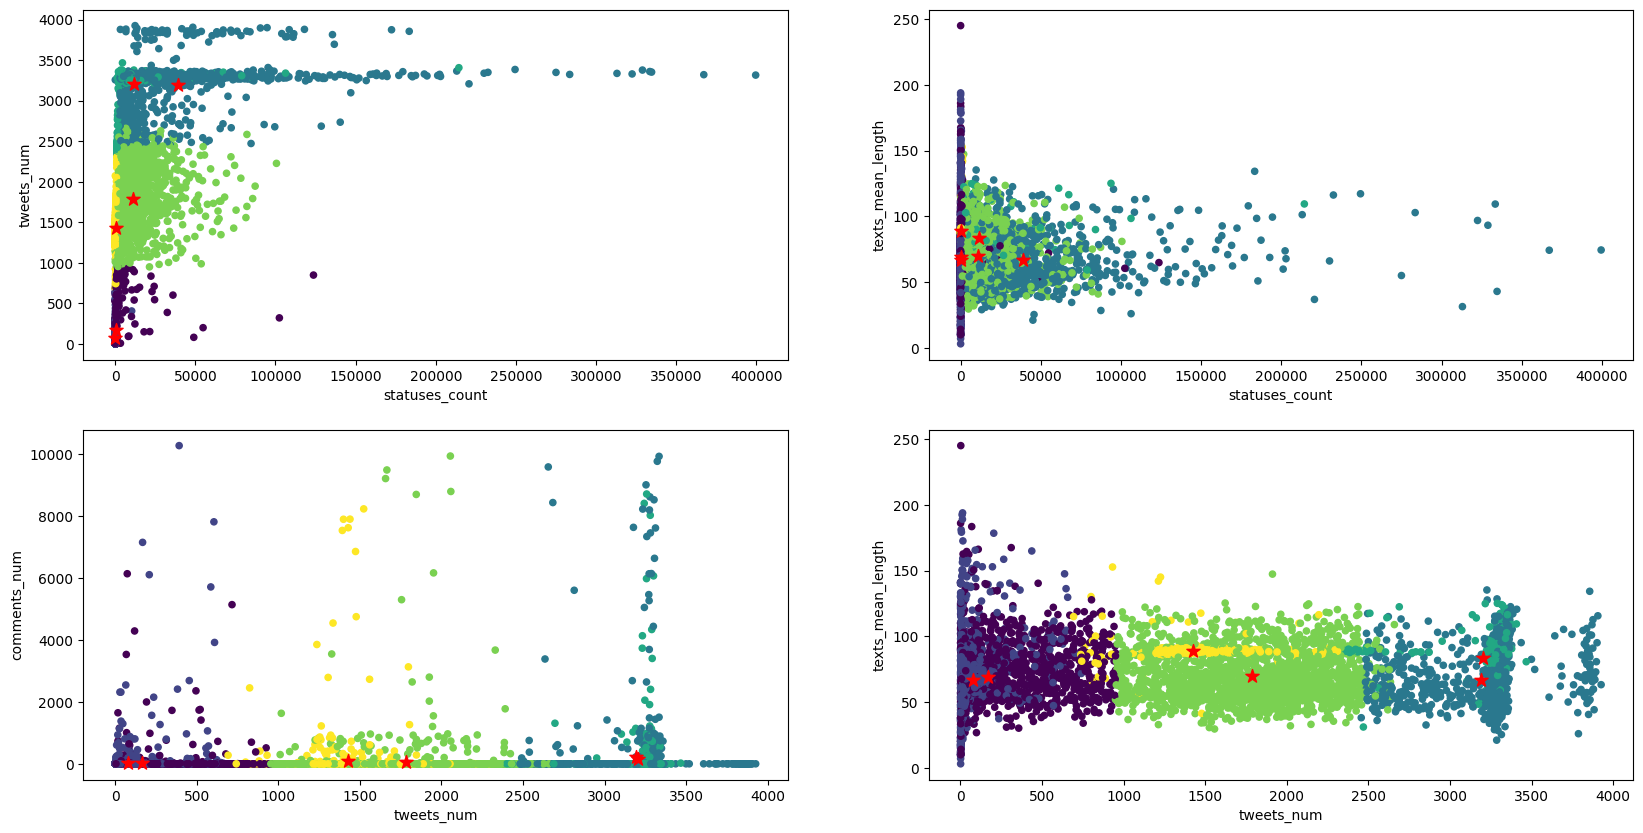

In [11]:
scatter_plt_pairs = [
    (0, 2),
    (0, 8),
    (2, 5),
    (2, 8),
]

configs = [
    {
        'type': 'scatter',
        'df': users_num,
        'labels': kmeans.labels_,
        'centers': centers,
        'x_index': x_index,
        'y_index': y_index,
    } for x_index, y_index in scatter_plt_pairs
]

build_grid_plot(configs=configs)

Bar plot able to show categorical attribute distribution among clusters.

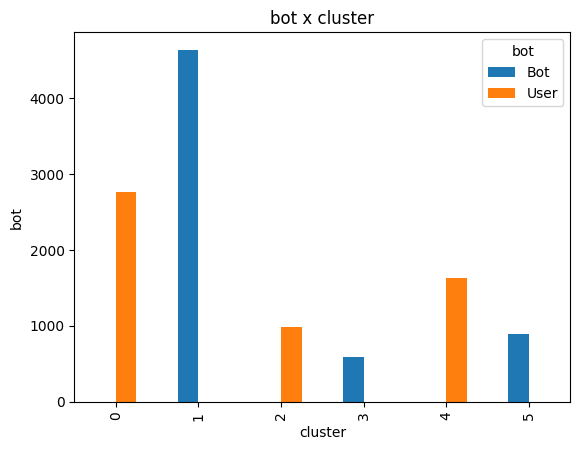

bot,Bot,User
row_0,,
0,0,2766
1,4635,0
2,0,991
3,585,0
4,0,1635
5,896,0


In [12]:
users_pct = pd.crosstab(kmeans.labels_, users_num['bot'].map(lambda x: 'Bot' if x else 'User'))

users_pct.plot(kind='bar', stacked=False, title='bot x cluster')
plt.xlabel('cluster')
plt.ylabel('bot')
plt.show()
users_pct

### DBSCAN

To choose a good model we start to scan with a gridsearch some values inside a DBSCAN model. We fix eps to 0.1 and take n values for test k. Using the silhouette metric we can understand the goodness of the model and choose the best.

In [13]:
best_k = None
best_metric = 0

for k in tqdm_notebook([10, 20, 50, 100, 150, 200, 500, 1000]):
    dbscan = DBSCAN(eps=0.1, min_samples=k)
    dbscan.fit(users_num_scaled)
    metric = silhouette_score(users_num_scaled, dbscan.labels_)
    if metric > best_metric:
        best_metric = metric
        best_k = k

k = best_k

lg.info(f'Best k is {best_k}')
lg.info(f'Best silhouette is {best_metric}')

/var/folders/mk/7s16j9k90j15d4m_gz0c5txc0000gn/T/ipykernel_1827/871137469.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook([10, 20, 50, 100, 150, 200, 500, 1000]):


  0%|          | 0/8 [00:00<?, ?it/s]

2022-12-18 16:17:25,441 - root - INFO - Best k is 200
2022-12-18 16:17:25,441 - root - INFO - Best silhouette is 0.6828783584232316


Here we compute the pairwise distances among `users_num_scaled` to use in knee method.

In [14]:
# pair wise distance
dist = pdist(users_num_scaled, 'euclidean')
# transformation of distance in square form
dist = squareform(dist)

lg.info(dist)

2022-12-18 16:17:26,088 - root - INFO - [[0.         1.00039501 0.25686932 ... 1.0028099  0.01595508 1.78019499]
 [1.00039501 0.         1.03704293 ... 0.06725471 1.00020942 1.48083594]
 [0.25686932 1.03704293 0.         ... 1.03001855 0.25928772 1.8430187 ]
 ...
 [1.0028099  0.06725471 1.03001855 ... 0.         1.0019488  1.53236416]
 [0.01595508 1.00020942 0.25928772 ... 1.0019488  0.         1.79176273]
 [1.78019499 1.48083594 1.8430187  ... 1.53236416 1.79176273 0.        ]]


Now we apply the knee method to understand the best number to assign to the radius dimension (eps) given the number of minimum points (k). To do this we take the k-th distances.

In [15]:
kth_distances = [d[np.argsort(d)[k]] for d in dist]

Plot related to the distances from k-th neigbours sorted. We use log scale on y axis to understand better the knee.

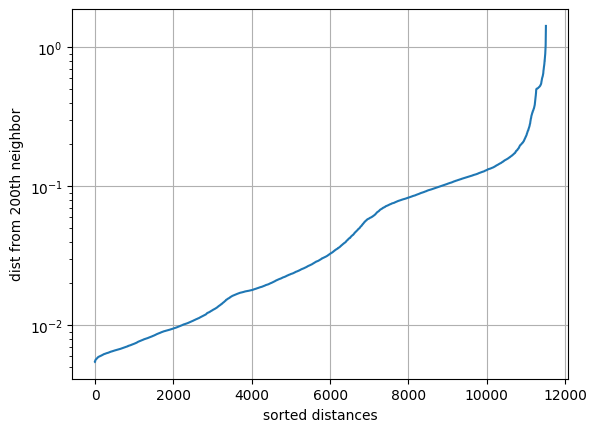

In [16]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel(f'dist from {k}th neighbor')
plt.xlabel('sorted distances')
plt.grid(True)
plt.yscale('log')
plt.show()

Construction of our DBSCAN model using fixed k and eps selected from the previous analysis.

In [17]:
dbscan = DBSCAN(eps=0.11, min_samples=k)
dbscan.fit(users_num_scaled)

lg.info(f'Silhouette {silhouette_score(users_num_scaled, dbscan.labels_)}')
lg.info(f'Separation {metrics.davies_bouldin_score(users_num_scaled, dbscan.labels_)}')

2022-12-18 16:17:35,722 - root - INFO - Silhouette 0.7060532907628265
2022-12-18 16:17:35,725 - root - INFO - Separation 1.486959709677283


Here we show in a bar-plot the labels distribution. -1 is related to outliers.

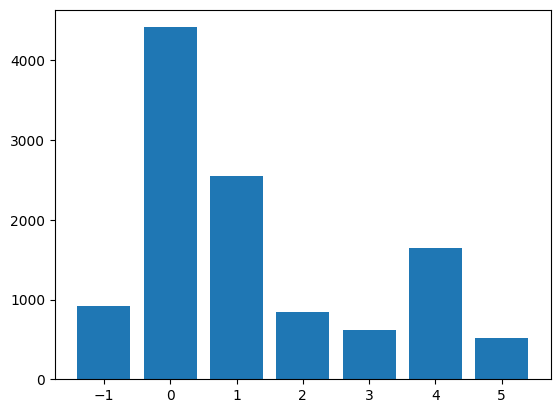

In [18]:
labels_distribution = np.unique(dbscan.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

Print the number of outliers detected from DBSCAN.

In [19]:
lg.info(f'Number of detected outliers: {labels_distribution[1][0]} ({labels_distribution[1][0] / len(users) * 100}%)')

2022-12-18 16:17:35,849 - root - INFO - Number of detected outliers: 923 (8.020507473062217%)


The following scatter-plots represents some analysis between some pairs of attributes of users_num dataset.

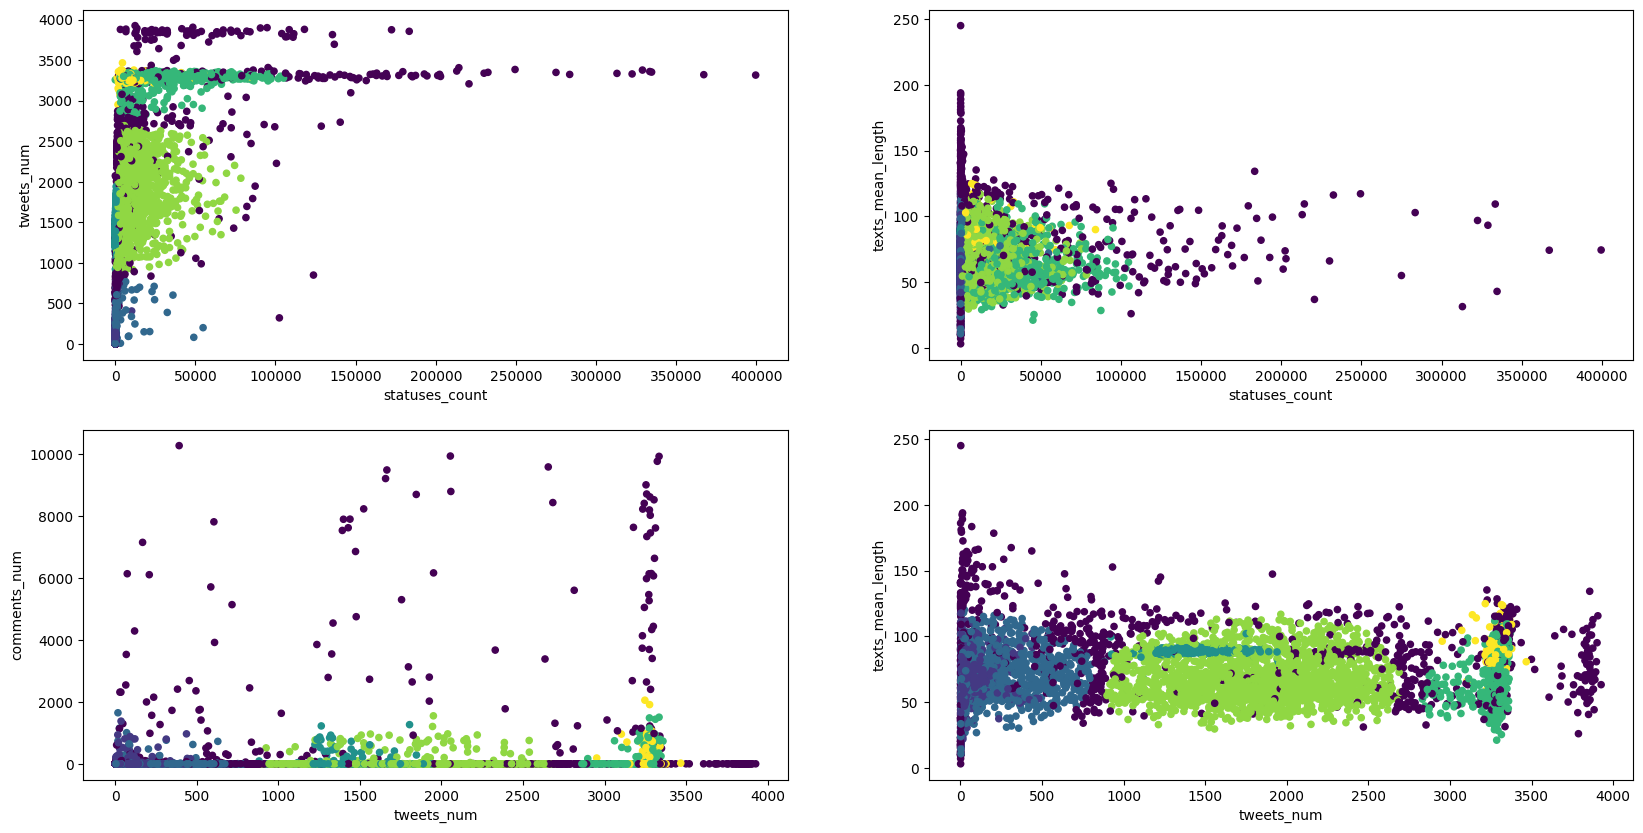

In [20]:
configs = [
    {
        'type': 'scatter',
        'df': users_num,
        'labels': dbscan.labels_,
        'x_index': x_index,
        'y_index': y_index,
    } for x_index, y_index in scatter_plt_pairs
]

build_grid_plot(configs=configs)

Bar plot able to show categorical attribute distribution among clusters.

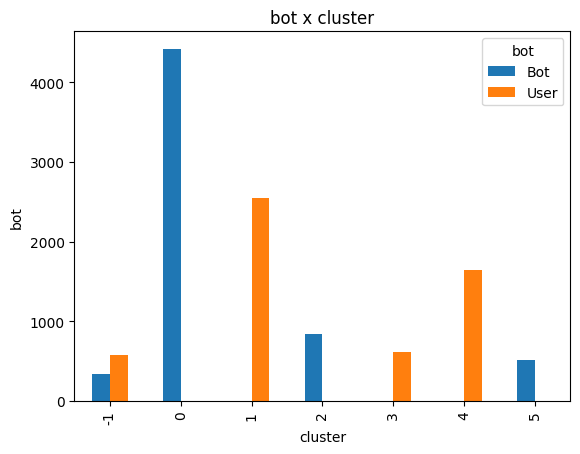

bot,Bot,User
row_0,,
-1,340,583
0,4416,0
1,0,2544
2,841,0
3,0,618
4,0,1647
5,519,0


In [21]:
users_pct = pd.crosstab(dbscan.labels_, users_num['bot'].map(lambda x: 'Bot' if x else 'User'))

users_pct.plot(kind='bar', stacked=False, title='bot x cluster')
plt.xlabel('cluster')
plt.ylabel('bot')
plt.show()
users_pct

## Hierarchical clustering

Hierarchical clustering technique is able to find dendograms that represents the division of different clusters according the eucledian distance. At the beginning we compute the distance matrix of `users_num_scaled` dataset.

In [22]:
data_dist = pdist(users_num_scaled, metric='euclidean')

Dendogram related to hierarchical clustering based on MIN link.

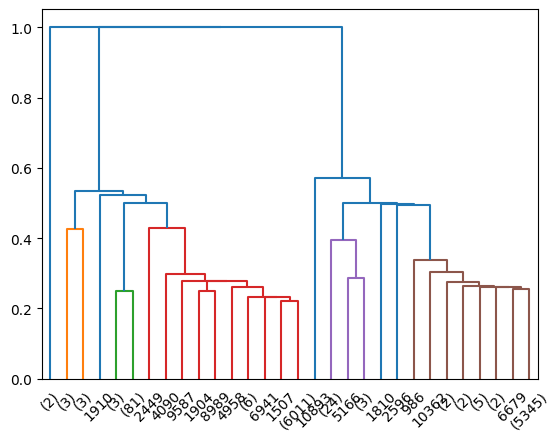

In [23]:
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.45, truncate_mode='lastp')

Dendogram related to hierarchical clustering based on MAX link.

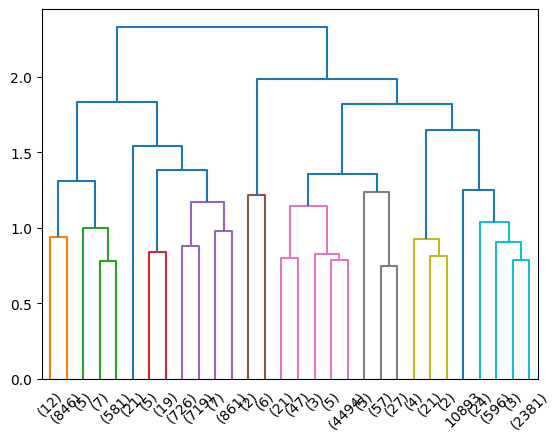

In [24]:
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.25, truncate_mode='lastp')

Dendogram related to hierarchical clustering based on average group link.

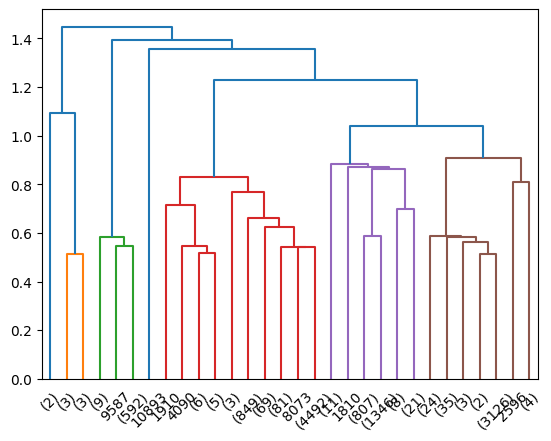

In [25]:
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=1, truncate_mode='lastp')

Dendogram related to hierarchical clustering based on clusters link.

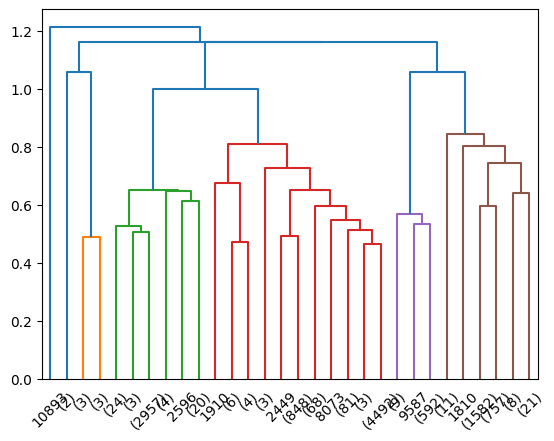

In [26]:
data_link = linkage(data_dist, method='centroid', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.9, truncate_mode='lastp')

## Advance clustering

### XMeans

X-means initializatioon and process.

In [28]:
# amount of initial centers defines amount of clusters from which X-Means will start analysis
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(users_num_scaled, amount_initial_centers).initialize()

# create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters to the assigned max
xmeans_instance = xmeans(users_num_scaled, initial_centers, 20)
xmeans_instance.process()

# extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

lg.info(f'Number of clusters: {len(clusters)}')

2022-12-18 16:18:03,098 - root - INFO - Number of clusters: 20


Some metrics calculations.

In [29]:
lg.info(f'SSE: {xmeans_instance.get_total_wce()}')
lg.info(f'Silhouette: {np.mean(silhouette(users_num_scaled, clusters).process().get_score())}')

2022-12-18 16:18:06,106 - root - INFO - SSE: 131.56845734210867
2022-12-18 16:18:19,383 - root - INFO - Silhouette: nan


Bar-plot used to understand the distribution among clusters.

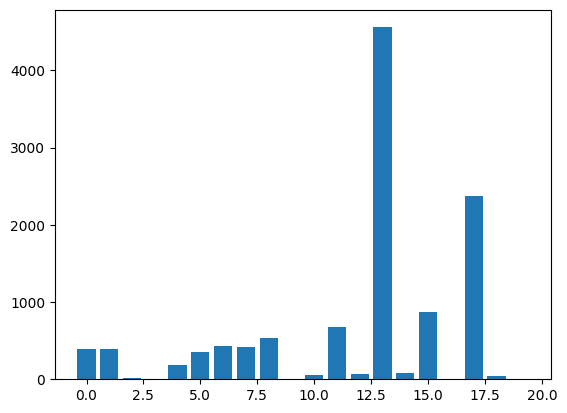

In [30]:
np_clusters = [len(c) for c in clusters]
plt.bar(list(range(len(np_clusters))), np_clusters)
plt.show()

Some scatter-plot to visualize clusters and centroids.

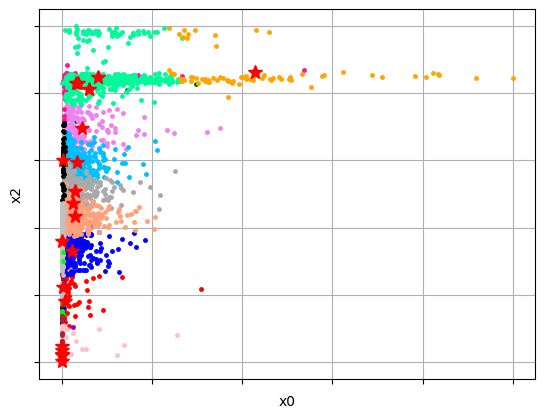

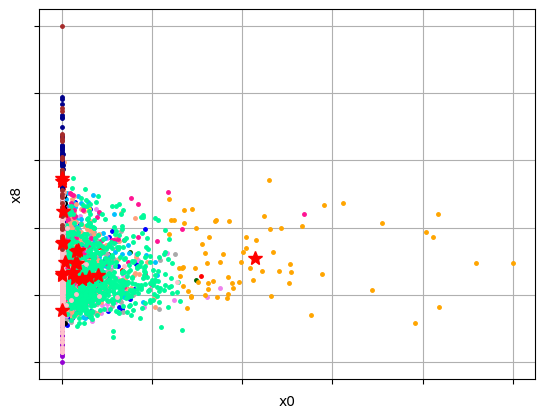

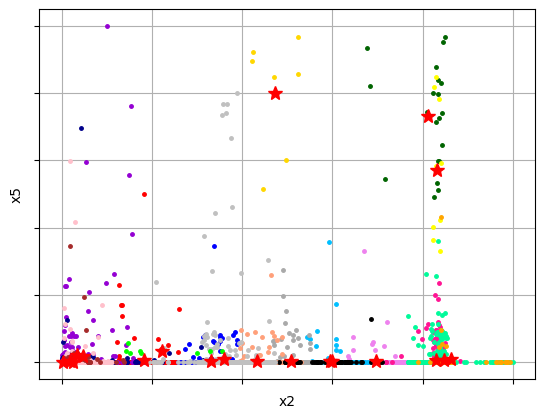

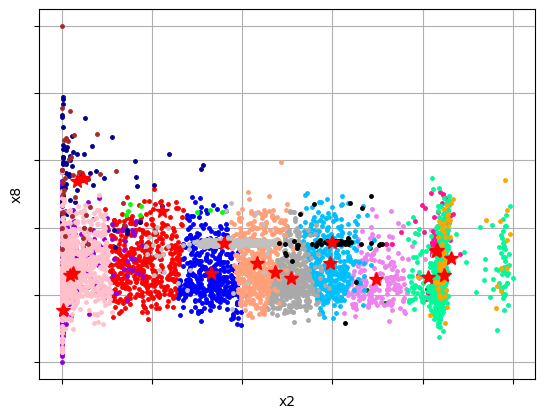

In [31]:
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, users_num_scaled.tolist())
visualizer.append_cluster(centers, None, marker='*', markersize=10, color='r')

for dim in scatter_plt_pairs:
    visualizer.show(pair_filter=[dim])

Bar plot able to show categorical attribute distribution among clusters.

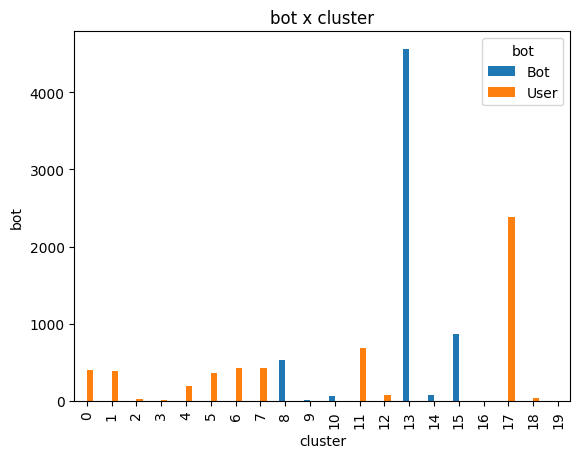

bot,Bot,User
row_0,,
0,0,398
1,0,394
2,0,20
3,0,7
4,0,190
5,0,356
6,0,432
7,0,421
8,535,0


In [32]:
cluster_list = [0 for i in range(users_num.shape[0])]
for i, cluster in enumerate(clusters):
    for item in cluster:
        cluster_list[item] = i
users_pct = pd.crosstab(np.array(cluster_list), users_num['bot'].map(lambda x: 'Bot' if x else 'User'))

users_pct.plot(kind='bar', stacked=False, title='bot x cluster')
plt.xlabel('cluster')
plt.ylabel('bot')
plt.show()
users_pct